In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torchvision.datasets import mnist
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from models.autoencoder import AutoEncoder
from IPython import display as ipd

In [14]:
ETA = 1e-3
BATCH_SIZE = 128
EPOCHS = 15

In [15]:
def train_step(context, x):
    autoencoder = context["autoencoder"]
    optimizer = context["optimizer"]

    optimizer.zero_grad()

    x_rec = autoencoder(x)
    loss = torch.mean(torch.sum((x - x_rec)**2, axis=(1, 2, 3)))

    loss.backward()
    optimizer.step()

    return x_rec, loss.item()

In [16]:
def eval_step(context, x):
    autoencoder = context["autoencoder"]

    x_rec = autoencoder(x)
    loss = torch.mean(torch.sum((x - x_rec)**2, axis=(1, 2, 3)))

    return x_rec, loss.item()

In [17]:
def visualize(x, x_rec):
    N = min(8, x.size(0))
    fig, axes = plt.subplots(N, 2, figsize=(8, 4*N))

    x = x.detach().cpu().numpy().squeeze() + 0.5
    x_rec = x_rec.detach().cpu().numpy().squeeze() + 0.5

    for i in range(N):
        axes[i, 0].imshow(x[i])
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])
        axes[i, 0].set_title("Original")

        axes[i, 1].imshow(x_rec[i])
        axes[i, 1].set_xticks([])
        axes[i, 1].set_yticks([])
        axes[i, 1].set_title("Reconstructed")

    plt.show()
    plt.close(fig)

In [18]:
def visualize_loss(train_losses, test_losses):
    fig, axes = plt.subplots(1, 2, figsize=(8, 8))

    axes[0].plot(train_losses)
    axes[0].set_title("Train loss")

    axes[1].plot(test_losses)
    axes[1].set_title("Test loss")

    plt.show()
    plt.close(fig)

In [19]:
def train_mode(context):
    for key in context.keys():
        if hasattr(context[key], "train"):
            context[key].train()

def eval_mode(context):
    for key in context.keys():
        if hasattr(context[key], "eval"):
            context[key].eval()

In [20]:
def train():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
    ])

    trainset = mnist.MNIST(root="D:/datasets/conda", train=True, transform=transform)
    testset = mnist.MNIST(root="D:/datasets/conda", train=False, transform=transform)

    train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

    autoencoder = AutoEncoder().cuda()
    optimizer = optim.AdamW(autoencoder.parameters(), lr=ETA)

    context = {
        "autoencoder": autoencoder,
        "optimizer": optimizer
    }

    train_losses = []
    test_losses = []

    for e in range(EPOCHS):
        train_loss = 0.0
        test_loss = 0.0

        train_mode(context)

        for x, _ in train_loader:
            x = x.cuda()
            x_rec, loss = train_step(context, x)
            train_loss += loss * (x.size(0) / len(trainset))

        eval_mode(context)

        with torch.no_grad():
            for x, _ in test_loader:
                x = x.cuda()
                x_rec, loss = eval_step(context, x)
                test_loss += loss * (x.size(0) / len(testset))

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        ipd.clear_output(wait=True)
        print(f"Epochs {e+1}/{EPOCHS}")
        print(f"Train loss: {train_loss:.8f}")
        print(f"Test loss: {test_loss:.8f}")

        visualize(x, x_rec)
        visualize_loss(train_losses, test_losses)

Epochs 15/15
Train loss: 0.65721145
Test loss: 0.84130420


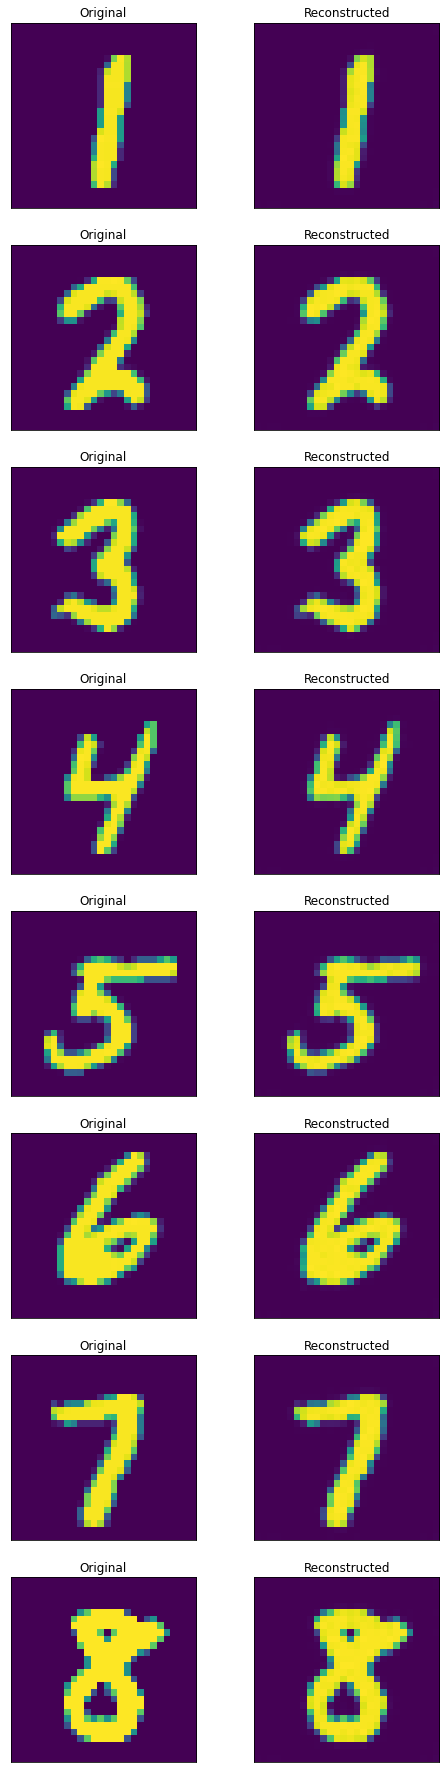

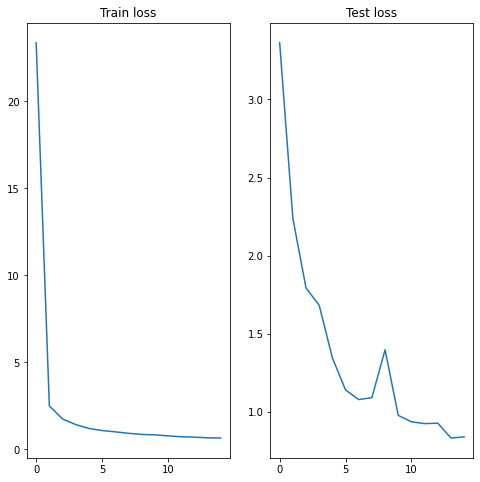

In [21]:
train()